# Heart Disease Logistic Regression Analysis

This notebook performs:
1. Data loading and target binarization
2. Exploratory Data Analysis (EDA)
3. Data preparation (train/test split, normalization)

**Note:** No high-level ML libraries (scikit-learn, statsmodels, TensorFlow, PyTorch) are used.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Heart_Disease_Prediction.csv')

# Display first few rows
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (270, 14)

First 5 rows:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [2]:
# Binarize the target column: 1 = Presence (disease), 0 = Absence (no disease)
df['Heart Disease Binary'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})

# Verify the mapping
print("Target column mapping:")
print(df[['Heart Disease', 'Heart Disease Binary']].drop_duplicates())
print("\nTarget distribution:")
print(df['Heart Disease Binary'].value_counts())

Target column mapping:
  Heart Disease  Heart Disease Binary
0      Presence                     1
1       Absence                     0

Target distribution:
Heart Disease Binary
0    150
1    120
Name: count, dtype: int64


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Summary statistics
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)
print("\nDataset Info:")
print(df.info())
print("\n" + "="*60)
print("Descriptive Statistics:")
print("="*60)
df.describe()

SUMMARY STATISTICS

Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    str    
 14  Hea

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease Binary
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


In [4]:
# Check for missing values
print("="*60)
print("MISSING VALUES CHECK")
print("="*60)
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")

MISSING VALUES CHECK

Missing values per column:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
Heart Disease Binary       0
dtype: int64

Total missing values: 0


In [5]:
# Outlier detection using IQR method for numerical columns
print("="*60)
print("OUTLIER DETECTION (IQR Method)")
print("="*60)

numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("\nOutliers per column:")
outlier_summary = []
for col in numerical_cols:
    n_outliers, lb, ub = detect_outliers_iqr(df, col)
    outlier_summary.append({'Column': col, 'Outliers': n_outliers, 'Lower Bound': lb, 'Upper Bound': ub})
    print(f"  {col}: {n_outliers} outliers (bounds: [{lb:.2f}, {ub:.2f}])")

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

OUTLIER DETECTION (IQR Method)

Outliers per column:
  Age: 0 outliers (bounds: [28.50, 80.50])
  BP: 9 outliers (bounds: [90.00, 170.00])
  Cholesterol: 5 outliers (bounds: [112.50, 380.50])
  Max HR: 1 outliers (bounds: [83.50, 215.50])
  ST depression: 4 outliers (bounds: [-2.40, 4.00])
  Number of vessels fluro: 19 outliers (bounds: [-1.50, 2.50])


,Column,Outliers,Lower Bound,Upper Bound
0,Age,0,28.5,80.5
1,BP,9,90.0,170.0
2,Cholesterol,5,112.5,380.5
3,Max HR,1,83.5,215.5
4,ST depression,4,-2.4,4.0
5,Number of vessels fluro,19,-1.5,2.5


In [6]:
# Handle outliers by capping (winsorizing) at IQR bounds
print("="*60)
print("HANDLING OUTLIERS (Capping at IQR bounds)")
print("="*60)

df_clean = df.copy()

for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    original_outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    print(f"  {col}: Capped {original_outliers} outliers")

print("\nOutliers handled successfully!")

HANDLING OUTLIERS (Capping at IQR bounds)
  Age: Capped 0 outliers
  BP: Capped 9 outliers
  Cholesterol: Capped 5 outliers
  Max HR: Capped 1 outliers
  ST depression: Capped 4 outliers
  Number of vessels fluro: Capped 19 outliers

Outliers handled successfully!


CLASS DISTRIBUTION


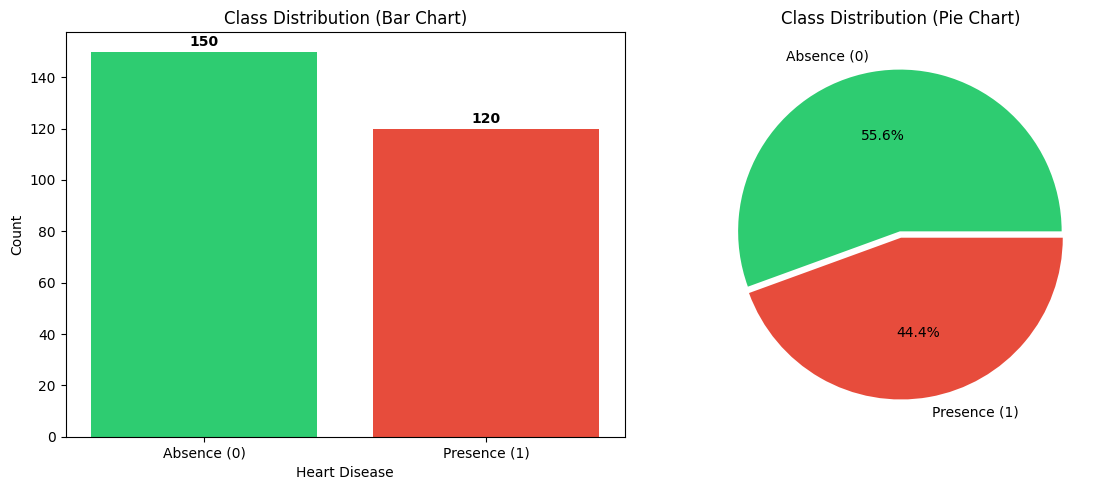


Class 0 (Absence): 150 (55.6%)
Class 1 (Presence): 120 (44.4%)


In [7]:
# Plot class distribution
print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
class_counts = df_clean['Heart Disease Binary'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Absence (0)', 'Presence (1)'], [class_counts[0], class_counts[1]], color=colors)
axes[0].set_xlabel('Heart Disease')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Bar Chart)')
for i, v in enumerate([class_counts[0], class_counts[1]]):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie([class_counts[0], class_counts[1]], 
            labels=['Absence (0)', 'Presence (1)'], 
            autopct='%1.1f%%',
            colors=colors,
            explode=(0.02, 0.02))
axes[1].set_title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

print(f"\nClass 0 (Absence): {class_counts[0]} ({class_counts[0]/len(df_clean)*100:.1f}%)")
print(f"Class 1 (Presence): {class_counts[1]} ({class_counts[1]/len(df_clean)*100:.1f}%)")

## 3. Data Preparation

### Feature Selection (≥6 features)
Selected features:
1. **Age** - Patient age
2. **BP** - Blood Pressure
3. **Cholesterol** - Cholesterol level
4. **Max HR** - Maximum Heart Rate
5. **ST depression** - ST depression induced by exercise
6. **Number of vessels fluro** - Number of major vessels colored by fluoroscopy

In [8]:
# Select features and target
selected_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

X = df_clean[selected_features].values
y = df_clean['Heart Disease Binary'].values

print("="*60)
print("FEATURE SELECTION")
print("="*60)
print(f"\nSelected {len(selected_features)} features: {selected_features}")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

FEATURE SELECTION

Selected 6 features: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']

Feature matrix shape: (270, 6)
Target vector shape: (270,)


In [9]:
# Stratified Train/Test Split (70/30) - Manual implementation without sklearn
def stratified_train_test_split(X, y, test_size=0.3, random_seed=42):
    """
    Manual implementation of stratified train-test split.
    Ensures both train and test sets have similar class proportions.
    """
    np.random.seed(random_seed)
    
    # Get indices for each class
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    # Shuffle indices
    np.random.shuffle(class_0_indices)
    np.random.shuffle(class_1_indices)
    
    # Calculate split points for each class
    n_test_class_0 = int(len(class_0_indices) * test_size)
    n_test_class_1 = int(len(class_1_indices) * test_size)
    
    # Split indices for each class
    test_indices_0 = class_0_indices[:n_test_class_0]
    train_indices_0 = class_0_indices[n_test_class_0:]
    
    test_indices_1 = class_1_indices[:n_test_class_1]
    train_indices_1 = class_1_indices[n_test_class_1:]
    
    # Combine indices
    train_indices = np.concatenate([train_indices_0, train_indices_1])
    test_indices = np.concatenate([test_indices_0, test_indices_1])
    
    # Shuffle combined indices
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    
    # Create train and test sets
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

# Perform stratified split
X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3, random_seed=42)

print("="*60)
print("STRATIFIED TRAIN/TEST SPLIT (70/30)")
print("="*60)
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(f"  Class 0: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"  Class 0: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

STRATIFIED TRAIN/TEST SPLIT (70/30)

Training set: 189 samples (70.0%)
Test set: 81 samples (30.0%)

Class distribution in training set:
  Class 0: 105 (55.6%)
  Class 1: 84 (44.4%)

Class distribution in test set:
  Class 0: 45 (55.6%)
  Class 1: 36 (44.4%)


In [10]:
# Feature Normalization (Min-Max Scaling) - Manual implementation
def min_max_normalize(X_train, X_test):
    """
    Manual implementation of Min-Max normalization.
    Fits on training data and transforms both train and test.
    Scales features to [0, 1] range.
    """
    # Calculate min and max from training data only
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    
    # Avoid division by zero
    X_range = X_max - X_min
    X_range[X_range == 0] = 1  # If range is 0, keep original values
    
    # Normalize
    X_train_normalized = (X_train - X_min) / X_range
    X_test_normalized = (X_test - X_min) / X_range
    
    return X_train_normalized, X_test_normalized, X_min, X_range

# Normalize features
X_train_norm, X_test_norm, norm_min, norm_range = min_max_normalize(X_train, X_test)

print("="*60)
print("FEATURE NORMALIZATION (Min-Max Scaling)")
print("="*60)
print("\nNormalization parameters (from training data):")
for i, feat in enumerate(selected_features):
    print(f"  {feat}: min={norm_min[i]:.2f}, range={norm_range[i]:.2f}")

print("\n" + "-"*60)
print("Training set - Before vs After normalization:")
print("-"*60)
for i, feat in enumerate(selected_features):
    print(f"  {feat}:")
    print(f"    Before: min={X_train[:, i].min():.2f}, max={X_train[:, i].max():.2f}")
    print(f"    After:  min={X_train_norm[:, i].min():.2f}, max={X_train_norm[:, i].max():.2f}")

FEATURE NORMALIZATION (Min-Max Scaling)

Normalization parameters (from training data):
  Age: min=34.00, range=43.00
  BP: min=94.00, range=76.00
  Cholesterol: min=126.00, range=254.50
  Max HR: min=83.50, range=111.50
  ST depression: min=0.00, range=4.00
  Number of vessels fluro: min=0.00, range=2.50

------------------------------------------------------------
Training set - Before vs After normalization:
------------------------------------------------------------
  Age:
    Before: min=34.00, max=77.00
    After:  min=0.00, max=1.00
  BP:
    Before: min=94.00, max=170.00
    After:  min=0.00, max=1.00
  Cholesterol:
    Before: min=126.00, max=380.50
    After:  min=0.00, max=1.00
  Max HR:
    Before: min=83.50, max=195.00
    After:  min=0.00, max=1.00
  ST depression:
    Before: min=0.00, max=4.00
    After:  min=0.00, max=1.00
  Number of vessels fluro:
    Before: min=0.00, max=2.50
    After:  min=0.00, max=1.00


In [11]:
# Summary of prepared data
print("="*60)
print("DATA PREPARATION SUMMARY")
print("="*60)
print(f"\n✓ Loaded dataset with {len(df)} samples")
print(f"✓ Binarized target: Presence=1, Absence=0")
print(f"✓ Handled outliers using IQR capping method")
print(f"✓ Selected {len(selected_features)} features: {selected_features}")
print(f"✓ Stratified 70/30 split: {len(X_train)} train / {len(X_test)} test")
print(f"✓ Normalized features using Min-Max scaling")
print(f"\nFinal data shapes:")
print(f"  X_train_norm: {X_train_norm.shape}")
print(f"  X_test_norm: {X_test_norm.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")
print("\n✓ Data is ready for logistic regression model training!")

DATA PREPARATION SUMMARY

✓ Loaded dataset with 270 samples
✓ Binarized target: Presence=1, Absence=0
✓ Handled outliers using IQR capping method
✓ Selected 6 features: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Number of vessels fluro']
✓ Stratified 70/30 split: 189 train / 81 test
✓ Normalized features using Min-Max scaling

Final data shapes:
  X_train_norm: (189, 6)
  X_test_norm: (81, 6)
  y_train: (189,)
  y_test: (81,)

✓ Data is ready for logistic regression model training!
